# Group atlas Training Example
This jupyter notebook demonstrates a minimal example for learning a new group parcellations using the Hierarchical Bayesian Parcellation framework. Previous studies use single datasets to generate group-level parcellation maps, which makes the parcellation less generalizable. To address this concern, our ``HierarchBayesParcel`` framework is designed to learn parcellation by fusing multiple datasets into a common probabilistic parcellation map that inherits the the combined strength of all datasets.

The pipeline has the following steps: 
* Preparing training data and their condition and partition vectors.
* Building the full model, consisting of a common arrangement model and dataset-specific emission models
* Training the model using Bayesian inference
* Saving and visualizing the resultant group atlas.

For data import and export we are using the [Functional_Fusion](https://github.com/DiedrichsenLab/Functional_Fusion) Framework, which needs to be installed in addition to the `HierarchBayesParcel` package.

In [1]:
import numpy as np
import torch as pt
import nibabel as nb
import nitools as nt
import pandas as pd
import matplotlib.pyplot as plt
import Functional_Fusion.atlas_map as am
import Functional_Fusion.dataset as ds
import HierarchBayesParcel.arrangements as ar
import HierarchBayesParcel.emissions as em
import HierarchBayesParcel.full_model as fm
import HierarchBayesParcel.util as ut
import SUITPy as suit

## Step 1: Define the the space in which to generate the group parcellations

This step defines the atlas space (e.g. fs32k, SUIT, MNISymC3, etc). An atlas in Functional_Fusion defines a specific set of brainlocations (grayordinates) in a specific group space (volume of surface-based). The data will need to be read into this space, and the resultant group atlas will be in this space.

Here we are using a cerebellar-only space, sampled at 3mm resolution with the MNI152NLin2009cSym template (MNISymC3). 

In [2]:
atlas, _ = am.get_atlas('MNISymC3')

## Step 2: Prepare training data

For model training, the data of all subjects needs to be arranged into a `num_subj` x `N` x `P` tensor, where N is the number of observations, and P is the number of brain locations (voxels). If the group atlas is desired to be trained from datasets fusion, the training data is a list of `num_subj` x `N` x `P` tensors with each one corresponding to one datasets.

In this example, we will train a group atlas from two datasets fusion, a task-based dataset `MDTB` and a resting-state dataset `HCP`. For MDTB dataset, we will use the activity estimates fro, task set A of all 24 subjects data with two repetitions. For HCP data, we use two cortical connectivity finger prints (correlation with 69 different ICA components) based on two resting-state imaging runs from the first 10 subjects of the *Unrelated 100 dataset*.  

To estimate the concentration parameter $\kappa$ efficiently, it is useful to have multiple measures of the same conditions. THe `HierarchBayesParcel` framework provides multiple choices when estimating $\kappa$, hence, efficiently capturing the measurement noise across sessions or functional regions (see the paper for more details). 

Depending on the goal in mind, user can applied different types of training model, then the preparation of data can be different. In this example, the type 2 fusion model will be used, which means there is an common $\kappa$ to quantify the overall measurement noise of the dataset.

### 2.1: Prepare the MDTB data

The MDTB task set A has 29 unique conditions, and there are two repetitions per condition.

In [3]:
data_dir = 'data_mdtb'
# Read the participant tsv file to get the name of the available subjects
subj_info = pd.read_csv(f'{data_dir}/participants.tsv',sep='\t')
data = []
# Read the data for each subject
for i, s in enumerate(subj_info['participant_id']):
        file_name = f'{data_dir}/{s}_space-{atlas.name}_ses-s1_CondHalf.dscalar.nii'
        datafile = nb.load(file_name)
        data.append(datafile.get_fdata())
# make the numsubj x numcond x numvoxel tensor
data_mdtb = np.stack(data)
print(data_mdtb.shape)

(24, 58, 5446)


Then, we make the condition and partition vectors for the data, where 1d vector `cond_v_mdtb` indicates the number of the condition and the 1d vector `part_v_mdtb` indicates the number of independent data partition (e.g. runs). **Note that the length of condition and partition vector should exactly match the second dimension of the data tensor**.

In [5]:
info = pd.read_csv(f'{data_dir}/info-CondHalf.tsv',sep='\t')
cond_v_mdtb = info['cond_num_uni'].values
part_v_mdtb = info['half'].values
print('condition vector: ', cond_v_mdtb)
print('partition vector: ', part_v_mdtb)

condition vector:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 24 25 26 27 28 29]
partition vector:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


### 2.2: Prepare the HCP data

The HCP example data is the resting-state functional connectivity profile from the first two runs (~15 min each). The connectivity profile at each cerebellar voxel was calculated as the correlation to the 69 spatial ICA network per each run.

In [6]:
data_dir = 'data_hcp'
# Read the participant tsv file to get the name of the available subjects
subj_info = pd.read_csv(f'{data_dir}/participants.tsv',sep='\t')
data = []
# Read the data for each subject
for i, s in enumerate(subj_info['participant_id']):
        file_name = f'{data_dir}/{s}_space-{atlas.name}_ses-rest1_Net69Run.dscalar.nii'
        datafile = nb.load(file_name)
        data.append(datafile.get_fdata())
# make the numsubj x numcond x numvoxel tensor
data_hcp = np.stack(data)
print(data_hcp.shape)

(10, 138, 5446)


Similarly, we make the condition (network number) and partition vector for the HCP data, where we treat each run as an independent repetition.

In [8]:
info = pd.read_csv(f'{data_dir}/info-Net69Run.tsv',sep='\t')
cond_v_hcp = info['net_id'].values
part_v_hcp = info['half'].values
print('condition vector: ', cond_v_hcp)
print('partition vector: ', part_v_hcp)

condition vector:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
partition vector:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


## Step 3: Build full model

First, the probabilistic atlas is encoded in the `arrangement model`. Depending on whether you want an symmetric or asymmetric individual parcellations, you can choose a `ArrangeIndependent` or `ArrangeIndependentSymmetric` model.

Second, we need to build a `emission model` for each of the datasets. In this example, we use a von-Mises-Fisher mixture model (`MixVMF`), which estimates the average functional profiles for each region ($V$) and a *common* concentration parameter ($\kappa$). Note that you could use also region- or subject-specific $\kappa$. 

Lastly, we assemble the arrangement and emission models into a `FullMultiModel` that will deal with the message-passing between the different model parts.

In [10]:
# Determine the resolution of the atlas (number of regions)
K=10

# Build spatial arrangement model
ar_model = ar.ArrangeIndependent(K, atlas.P, spatial_specific=True, 
                                 remove_redundancy=False)

# Build emission models for each dataset
em_model_mdtb = em.MixVMF(K=K, P=atlas.P, X=ut.indicator(cond_v_mdtb),
                          part_vec=part_v_mdtb)
em_model_hcp = em.MixVMF(K=K, P=atlas.P, X=ut.indicator(cond_v_hcp),
                         part_vec=part_v_hcp)

# Assemble the full model
M = fm.FullMultiModel(ar_model, [em_model_mdtb, em_model_hcp])

**Note, that there are many choices for the exact model specification and data preparation,** all of which will influence the quality of the final probabilistic group atlas. In this example, we are only choosing one option to illustrate the practical steps. In general, you should critically evaluate different model types to achieve the best fusion group parcellation.

## Step 4: Fit the full model
Now, we initialize the full model by passing a list of the data set. Note, `subj_ind='separate'` indicates the two datasets are from different set of participants. If the two datasets contain the same set of subjects, or have partially overlapping sets of subjects, then we pass a list of unique subject index to tell the full model the identity of each subject in each dataset. 

In [11]:
M.initialize([data_mdtb, data_hcp], subj_ind='separate')
# Since we use spatial independent model, here we will use EM training
# with 50 random initializations.  
M_fused, ll, _, U_indiv_fuse, _ = M.fit_em_ninits(iter=200, tol=0.01, fit_arrangement=True,
                                                  fit_emission=True, init_arrangement=True,
                                                  init_emission=True, n_inits=50, first_iter=30, 
                                                  verbose=False)

/Users/jdiedrichsen/Python/HierarchBayesParcel/HierarchBayesParcel/full_model.py:305: UserWarning: Likelihood decreased - terminating on iteration 70
  warnings.warn(f'Likelihood decreased - terminating on iteration {i}')


## Step 5: Visualize the group parcellations

Lastly, we can visually inspect the resulting parcellation by using the SUITPy toolbox to visualize these on the surface.

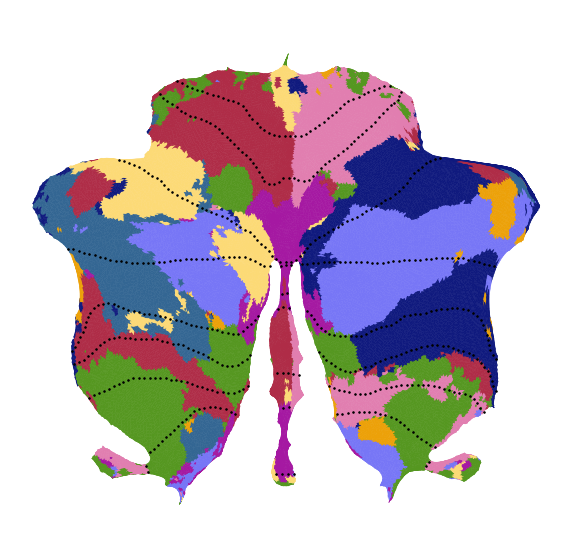

In [12]:
def plot_probseg(nifti,cmap):
    # Project the nifti image to the surface over the MNISymC space
    surf_data = suit.flatmap.vol_to_surf(nifti, stats='nanmean',space='MNISymC')
    label = np.argmax(surf_data, axis=1)+1

    suit.flatmap.plot(label,
        render='matplotlib',
        cmap=cmap,
        cscale=[0,31],
        label_names = names,
        new_figure=False,
        overlay_type='label',
        bordersize=3,
    )

# Load colormap and labels
lid,cmap,names = nt.read_lut('atl-MDTB10.lut')
# Make a nifti image of the first subject
nifti = atlas.data_to_nifti(M_fused.arrange.marginal_prob().numpy())
# Make a figure
plt.figure(figsize=(10,10))
# plot the group probabilistic atlas
plot_probseg(nifti,cmap)

This concludes a our example. Belows we are provide some useful more advance tips for our framework.
<hr>

## Comparison of fusion atlas vs. single-dataset atlas
For comparison we can also train the group atlas on each dataset alone and compare the results. 

In [10]:
# Train MDTB parcellation only
M1 = fm.FullMultiModel(ar_model, [em_model_mdtb])
M1.initialize([data_mdtb])
M1, ll, theta, U_hat, _ = M1.fit_em_ninits(iter=200, tol=0.01, fit_arrangement=True,
                                           fit_emission=True, init_arrangement=True,
                                           init_emission=True, n_inits=50, first_iter=30, 
                                           verbose=False)

# Train HCP parcellation only
M2 = fm.FullMultiModel(ar_model, [em_model_hcp])
M2.initialize([data_hcp])
M2, ll, theta, U_hat, _ = M2.fit_em_ninits(iter=200, tol=0.01, fit_arrangement=True,
                                           fit_emission=True, init_arrangement=True,
                                           init_emission=True, n_inits=50, first_iter=30, 
                                           verbose=False)


/home/ROBARTS/dzhi/WorkSpace/HierarchBayesParcel/HierarchBayesParcel/full_model.py:305: UserWarning: Likelihood decreased - terminating on iteration 53
  warnings.warn(f'Likelihood decreased - terminating on iteration {i}')
/home/ROBARTS/dzhi/WorkSpace/HierarchBayesParcel/HierarchBayesParcel/full_model.py:305: UserWarning: Likelihood decreased - terminating on iteration 37
  warnings.warn(f'Likelihood decreased - terminating on iteration {i}')


Different datasets highlight different functional region. However, the fused map shows the combined strength. For example, in this case, the group map trained by resting-state alone cannot predict left- and right hand motor areas. But these motor regions are visible now in the fusion map.

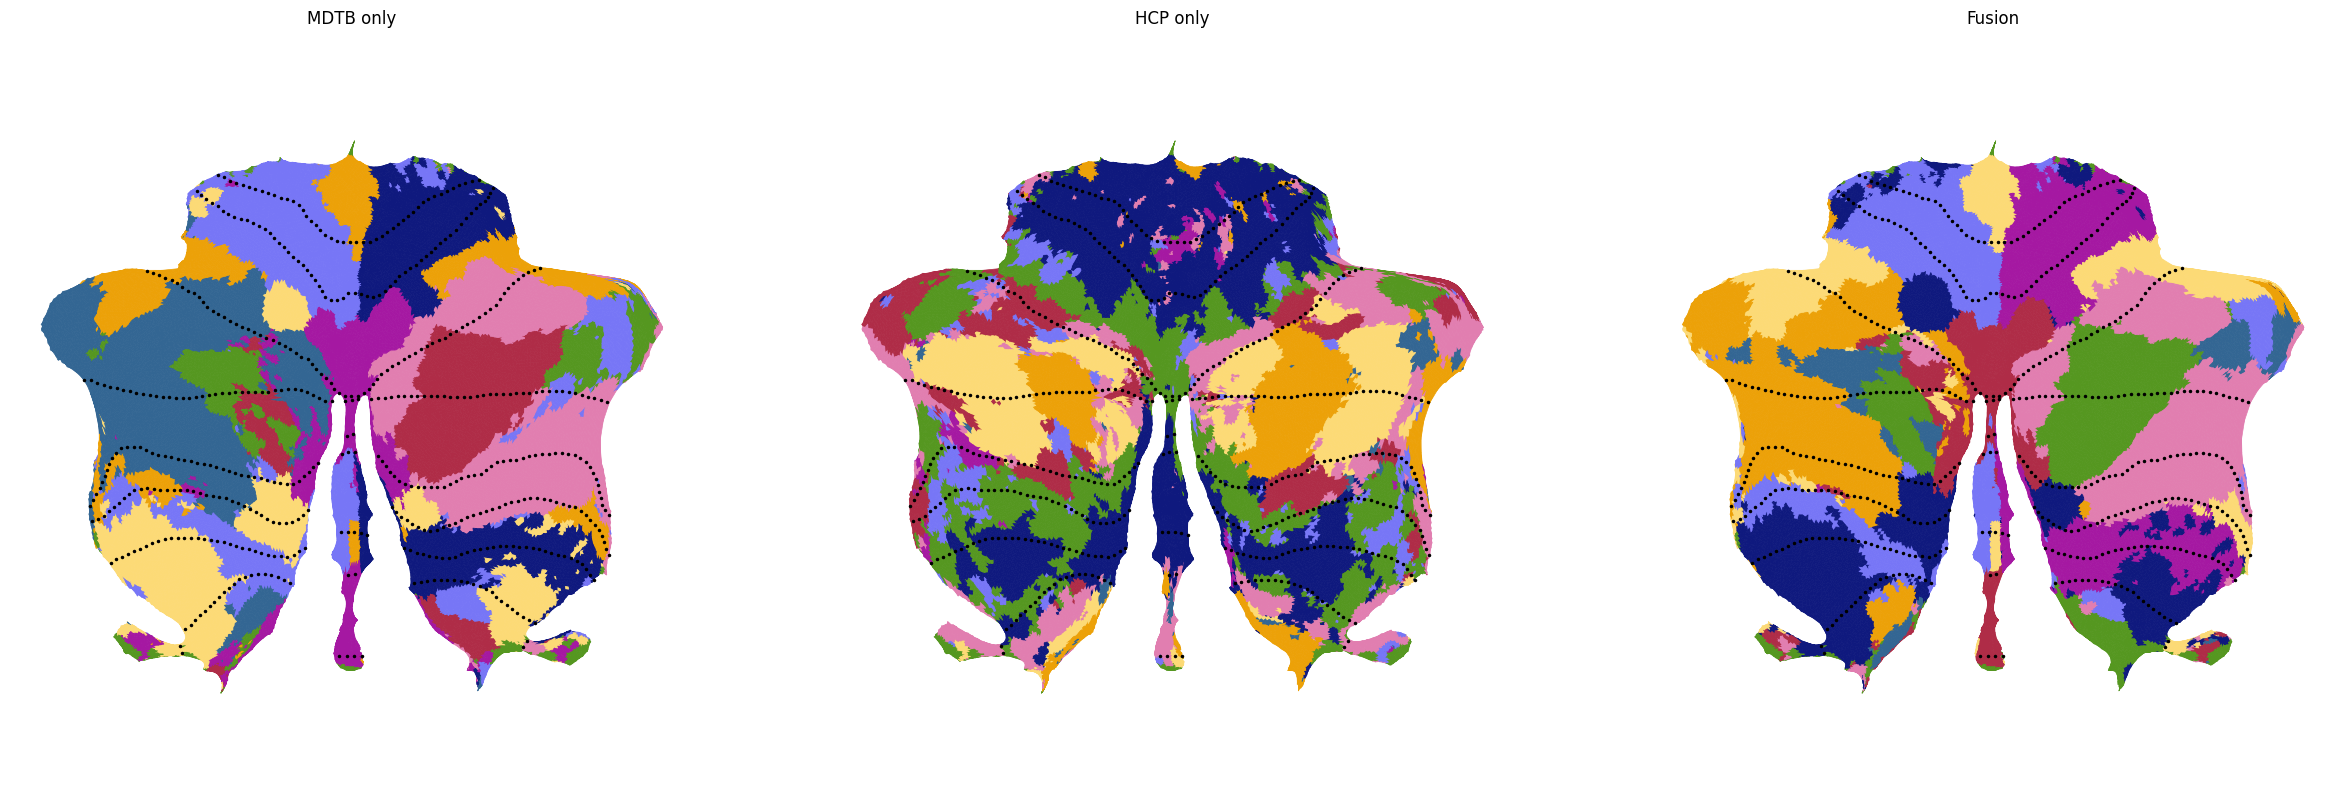

In [11]:
# plot comparison
plt.figure(figsize=(30,10))
plt.subplot(1,3,1, title='MDTB only')
nifti = atlas.data_to_nifti(pt.softmax(M1.arrange.logpi, dim=0).numpy())
plot_probseg(nifti,cmap)

plt.subplot(1,3,2, title='HCP only')
nifti = atlas.data_to_nifti(pt.softmax(M2.arrange.logpi, dim=0).numpy())
plot_probseg(nifti,cmap)

plt.subplot(1,3,3, title='Fusion')
nifti = atlas.data_to_nifti(pt.softmax(M_fused.arrange.logpi, dim=0).numpy())
plot_probseg(nifti,cmap)

## Monitoring the model training
When using a spatial independent arrangement model (including symmetric or asymmetric version), the `HierarchBayesParcel` framework uses a EM-like algorithm to maximize the objective function. In the full model fit function `fit_em_ninits()`, we also output the expected completed likelihood `ll` for each learning iteration of the best of the 50 random initializations. A visualization of the curve can help to monitor the model training. By observing the learning curve, it also gives user good intuition to fine-tuning their learning process, such as the maximum EM iteration, stopping criteria, and other hyper-parameters. 

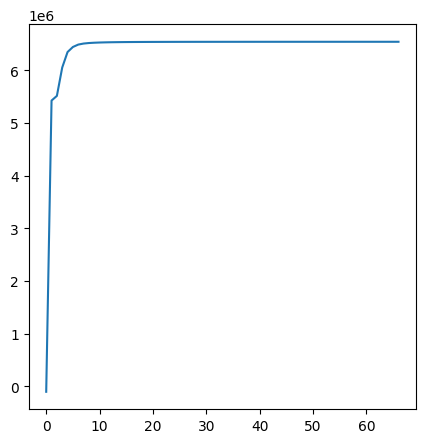

In [12]:
plt.figure(figsize=(5,5))
plt.plot(ll)

## Concentration parameter $\kappa$

Another useful tool to find whether the learning precedes correctly is to check the estimated concentration parameter $\kappa$. In the type 2 model we using a common $\kappa$ across all functional regions, whereas in the type 3 model a region-specific $\kappa$ will be learned. The concentration parameter $\kappa$ is a positive scale to indicate how spread the data points are around the mean direction in high dimensional space, a higher value means the data points are more concentrated around the mean. If one or more values are observed to be abnormally low or high, it is a signal something happened in the learning.

In [13]:
print(M_fused.emissions[0].kappa, M_fused.emissions[1].kappa)

tensor(16.5936) tensor(55.7207)


## Individual parcellations directly estimated from the group training

After training, the `HierarchBayesParcel` framework not only provides a group map, but also the individual parcellations for all the training subjects. These individual parcellations are equivalent to run the E-step of the fitted model on this data. (see `individual_parcellation_example.ipynb` for more details)

In [14]:
print(U_indiv_fuse.shape, M_fused.Estep()[0].shape)

torch.Size([34, 10, 5446]) torch.Size([34, 10, 5446])


## Avoid local maxima - use many optimization runs 
Deriving a parcellation map is a highly non-convex problem with many local maxima.  
A first line of defense `fit_em_niits()`, initialize the model from many (`n_inits`) different random starting points, performing only a few learning iterations (`first_iter`). After this initial phase of learning, the function picks the model with the highest expected log-likelihood, and only completes the training on this model. Training stops when the likelihood increased less than (`tol`) in a single step or when `iter` iterations are reached. 

In practice, we highly recommend repeating this process a large number of times, until the solution with the highest fnal likelihood was found at least 10 times in independent learning runs. This increases our confidence that we had found a solution that may constitute a global maximum (but of course it is no guarantee for it).

Please find [this example](https://github.com/DiedrichsenLab/FusionModel/blob/main/learn_fusion_gpu.py) for more details.

## GPU acceleration

It is strongly recommended to use GPU to train the group atlas, which dramatically speeds up the training time. All code was written in python and native PyTorch that can be easily deployed on GPU. 